In [17]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
writer = SummaryWriter('runs/sign_language_digits_experiment_1')

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
class SignLanguageDigitsDataset(Dataset):

    def __init__(self):
        self.x = torch.from_numpy(np.load('./X.npy'))
        self.y = torch.from_numpy(np.load('./Y.npy'))

        self.x = self.x.unsqueeze(1)
        self.y = torch.argmax(self.y, dim=1)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [21]:
dataset = SignLanguageDigitsDataset()
len(dataset)

2062

In [22]:
train_set, test_set = train_test_split(dataset, test_size=0.20)

print(len(train_set))
print(len(test_set))

1649
413


In [23]:
image, label = dataset[1600]
print(image)
print(label)

tensor([[[0.8039, 0.7922, 0.7843,  ..., 0.8275, 0.8196, 0.8039],
         [0.7961, 0.7922, 0.7765,  ..., 0.8235, 0.8196, 0.8078],
         [0.7961, 0.7961, 0.7843,  ..., 0.8196, 0.8196, 0.8157],
         ...,
         [0.6588, 0.6784, 0.7137,  ..., 0.7059, 0.7020, 0.7020],
         [0.6588, 0.6784, 0.7059,  ..., 0.7020, 0.6980, 0.6980],
         [0.6510, 0.6706, 0.6980,  ..., 0.6941, 0.6980, 0.6980]]])
tensor(7)


In [24]:
train_loader = DataLoader(dataset=train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=4, shuffle=True)

data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([4, 1, 64, 64])
torch.Size([4])


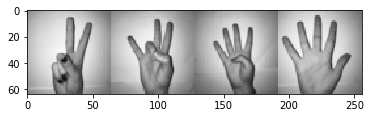

In [9]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

plt.imshow(images[0][0], cmap='gray')
grid = torchvision.utils.make_grid(images, nrow=4, padding=0)
show(grid)

In [10]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*6*6, 128) # 64 filters of 6x6 images after 3 max pooling 2D
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

net = ConvNet()

In [11]:
epochs = 25
learning_rate = 0.001

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
total_step = len(train_loader)
running_loss = 0.0
running_correct = 0.0

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))
            
            # Tensorboard
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * len(train_loader) + i)
            running_loss = 0.0
            running_correct = 0.0

print('Finished Training')

Epoch [1/25], Step [100/413], Loss: 0.0001
Epoch [1/25], Step [200/413], Loss: 0.0000
Epoch [1/25], Step [300/413], Loss: 0.0000
Epoch [1/25], Step [400/413], Loss: 0.0000
Epoch [2/25], Step [100/413], Loss: 0.0001
Epoch [2/25], Step [200/413], Loss: 0.0001
Epoch [2/25], Step [300/413], Loss: 0.0001
Epoch [2/25], Step [400/413], Loss: 0.0000
Epoch [3/25], Step [100/413], Loss: 0.0000
Epoch [3/25], Step [200/413], Loss: 0.0000
Epoch [3/25], Step [300/413], Loss: 0.0000
Epoch [3/25], Step [400/413], Loss: 0.0000
Epoch [4/25], Step [100/413], Loss: 0.0000
Epoch [4/25], Step [200/413], Loss: 0.0001
Epoch [4/25], Step [300/413], Loss: 0.0000
Epoch [4/25], Step [400/413], Loss: 0.0000
Epoch [5/25], Step [100/413], Loss: 0.0000
Epoch [5/25], Step [200/413], Loss: 0.0000
Epoch [5/25], Step [300/413], Loss: 0.0000
Epoch [5/25], Step [400/413], Loss: 0.0000
Epoch [6/25], Step [100/413], Loss: 0.0000
Epoch [6/25], Step [200/413], Loss: 0.0000
Epoch [6/25], Step [300/413], Loss: 0.0000
Epoch [6/25

In [16]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 413 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 413 test images: 94.43099273607749 %
